In [3]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import os
import datetime as dt
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

%config IPCompleter.greedy=True

In [4]:
print(os.getcwd())

/Users/montealvo/Documents/SB_DataScience/Capstone/Mass_Mobilization


In [5]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Table of Contents

   * [Data Loading](#data_load)
   * [Feature Importance](#feat_import)  
   * [Logistic Regression](#Log) 
   * [Random Forest](#random_forest) 
   * [Gradient Boosting](#gradient) 


## Data loading <a class="anchor" id="data_load"></a>

Importing file from where we left off after EDA.

In [6]:
df3 = pd.read_csv('../Mass_Mobilization/df3.csv')

In [7]:
df3.head()

,country,region,year,startmonth,participants_int,new_participants_category,labor_wage_dispute,land_farm_issue,police_brutality,political_behavior,...,demands_count,responses_count,start_date,end_date,protesterviolence,Violent_Response,hemisphere,season,dur_column,dur_column2
0,Canada,North America,1990,1.0,1500.0,1000-1999,True,False,False,True,...,2,1,1990-01-15,1990-01-15,False,False,northern,winter,1,1
1,Canada,North America,1990,6.0,1000.0,1000-1999,False,False,False,True,...,1,1,1990-06-25,1990-06-25,False,False,northern,summer,1,1
2,Canada,North America,1990,7.0,500.0,100-999,False,False,False,True,...,1,1,1990-07-01,1990-07-01,False,False,northern,summer,1,1
3,Canada,North America,1990,7.0,550.0,100-999,False,True,False,False,...,1,1,1990-07-12,1990-09-06,True,False,northern,summer,57,7+
4,Canada,North America,1990,8.0,950.0,100-999,False,False,False,True,...,1,3,1990-08-14,1990-08-15,True,False,northern,summer,2,2


In [8]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14482 entries, 0 to 14481
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     14482 non-null  object 
 1   region                      14482 non-null  object 
 2   year                        14482 non-null  int64  
 3   startmonth                  14482 non-null  float64
 4   participants_int            14465 non-null  float64
 5   new_participants_category   14465 non-null  object 
 6   labor_wage_dispute          14482 non-null  bool   
 7   land_farm_issue             14482 non-null  bool   
 8   police_brutality            14482 non-null  bool   
 9   political_behavior          14482 non-null  bool   
 10  price_increases_tax_policy  14482 non-null  bool   
 11  removal_of_politician       14482 non-null  bool   
 12  social_restrictions         14482 non-null  bool   
 13  protesterdemand1_y          144

In [9]:
df_target = df3[['Violent_Response']]

In [10]:
df_target.head()

,Violent_Response
0,False
1,False
2,False
3,False
4,False


In [11]:
#dropping "duplicate" columns that are represented elsewhere in the df, as well as any target data and "future" data
df3.drop(columns=['participants_int','protesterdemand1_y','protesterdemand2_y','protesterdemand3_y','protesterdemand4_y','stateresponse1_y','stateresponse2_y','stateresponse3_y','stateresponse4_y','stateresponse5_y','stateresponse6_y','stateresponse7_y', 'start_date','end_date','Violent_Response','accomodation','arrests','beatings','crowd_dispersal','ignore','killings','shootings','first_response','last_response', 'responses_count','protesterviolence','dur_column','dur_column2' ] , inplace=True)

In [12]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14482 entries, 0 to 14481
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     14482 non-null  object 
 1   region                      14482 non-null  object 
 2   year                        14482 non-null  int64  
 3   startmonth                  14482 non-null  float64
 4   new_participants_category   14465 non-null  object 
 5   labor_wage_dispute          14482 non-null  bool   
 6   land_farm_issue             14482 non-null  bool   
 7   police_brutality            14482 non-null  bool   
 8   political_behavior          14482 non-null  bool   
 9   price_increases_tax_policy  14482 non-null  bool   
 10  removal_of_politician       14482 non-null  bool   
 11  social_restrictions         14482 non-null  bool   
 12  demands_count               14482 non-null  int64  
 13  hemisphere                  144

In [13]:
#Creating new df with dummy columns
df_encoded = pd.get_dummies(df3, columns=None)

In [14]:
df_encoded

,year,startmonth,labor_wage_dispute,land_farm_issue,police_brutality,political_behavior,price_increases_tax_policy,removal_of_politician,social_restrictions,demands_count,...,new_participants_category_2000-4999,new_participants_category_50-99,new_participants_category_5000-10000,new_participants_category_>10000,hemisphere_northern,hemisphere_southern,season_autumn,season_spring,season_summer,season_winter
0,1990,1.0,True,False,False,True,False,False,False,2,...,0,0,0,0,1,0,0,0,0,1
1,1990,6.0,False,False,False,True,False,False,False,1,...,0,0,0,0,1,0,0,0,1,0
2,1990,7.0,False,False,False,True,False,False,False,1,...,0,0,0,0,1,0,0,0,1,0
3,1990,7.0,False,True,False,False,False,False,False,1,...,0,0,0,0,1,0,0,0,1,0
4,1990,8.0,False,False,False,True,False,False,False,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14477,2014,2.0,False,False,False,True,False,False,False,1,...,0,0,0,0,0,1,0,0,1,0
14478,2016,5.0,False,False,False,False,False,True,False,1,...,0,0,0,0,0,1,1,0,0,0
14479,2017,6.0,False,True,False,True,False,False,False,2,...,0,1,0,0,0,1,0,0,0,1
14480,2017,7.0,False,False,False,True,False,False,False,1,...,0,1,0,0,0,1,0,0,0,1


In [15]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14482 entries, 0 to 14481
Columns: 197 entries, year to season_winter
dtypes: bool(7), float64(1), int64(2), uint8(187)
memory usage: 3.0 MB


In [16]:
df_encoded.columns

Index(['year', 'startmonth', 'labor_wage_dispute', 'land_farm_issue',
       'police_brutality', 'political_behavior', 'price_increases_tax_policy',
       'removal_of_politician', 'social_restrictions', 'demands_count',
       ...
       'new_participants_category_2000-4999',
       'new_participants_category_50-99',
       'new_participants_category_5000-10000',
       'new_participants_category_>10000', 'hemisphere_northern',
       'hemisphere_southern', 'season_autumn', 'season_spring',
       'season_summer', 'season_winter'],
      dtype='object', length=197)

In [17]:
df_encoded.to_csv('df_encoded.csv', index=False)

## Feature Importance <a class="anchor" id="feat_import"></a>

In [18]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [19]:
X = pd.DataFrame(df_encoded, columns=df_encoded.columns)
y = np.ravel(df_target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [20]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [21]:
rf.feature_importances_

array([1.97188904e-01, 1.32415894e-01, 1.63195814e-02, 8.72298389e-03,
       1.43946720e-02, 2.65495181e-02, 1.43875567e-02, 1.58355169e-02,
       6.53232110e-03, 2.31137471e-02, 5.97750386e-04, 2.06606236e-03,
       2.68682026e-03, 1.34642534e-03, 6.24181032e-04, 7.94744268e-04,
       1.67665376e-04, 1.61716551e-03, 1.62348996e-03, 8.54109991e-03,
       9.08685306e-04, 0.00000000e+00, 5.19410817e-04, 4.94818769e-04,
       1.60698342e-03, 4.17662347e-04, 8.43864751e-04, 1.21011706e-03,
       2.70213377e-04, 9.20665935e-04, 3.02976655e-03, 2.42649765e-03,
       3.11761596e-03, 2.69975482e-04, 0.00000000e+00, 3.57336487e-03,
       1.67012159e-03, 8.08541666e-04, 3.82570996e-03, 9.43706427e-04,
       2.68235098e-03, 1.37398900e-03, 4.77221515e-03, 4.58314569e-04,
       0.00000000e+00, 4.05059316e-04, 0.00000000e+00, 0.00000000e+00,
       2.27111034e-06, 4.74772744e-04, 1.57731296e-03, 2.94508099e-03,
       1.22210954e-03, 4.37259901e-03, 1.22668622e-03, 1.82673539e-04,
      

In [22]:
list_of_tuples = list(zip(df_encoded.columns, rf.feature_importances_)) 

In [23]:
df_rf = pd.DataFrame(list_of_tuples, columns = ['feature', 'importance']) 

In [24]:
sorted_feat20 = df_rf.nlargest(20,'importance')

In [25]:
sorted_feat20.head()

,feature,importance
0,year,0.197189
1,startmonth,0.132416
185,new_participants_category_100-999,0.038599
179,region_Europe,0.033347
5,political_behavior,0.026550


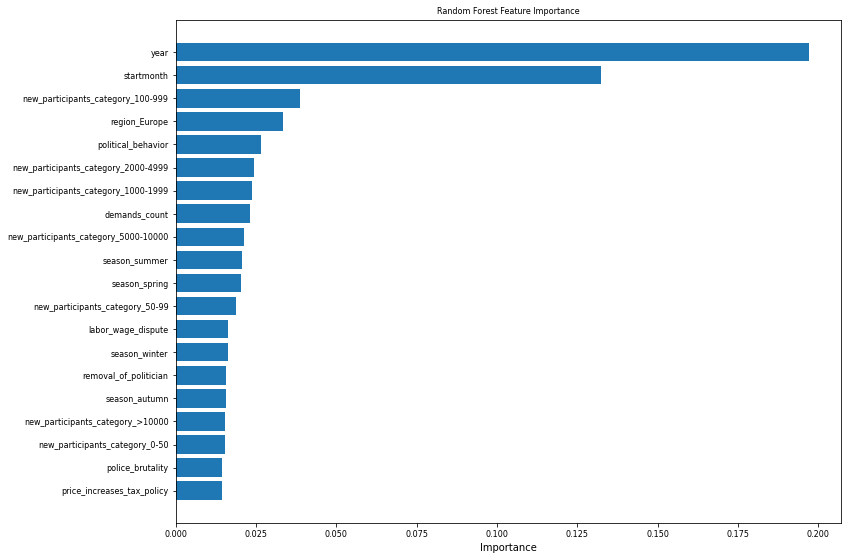

In [26]:
plt.barh('feature','importance',data=sorted_feat20)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig('15_Feature_Importance.png')

In [27]:
sorted_feat50 = df_rf.nlargest(50,'importance')

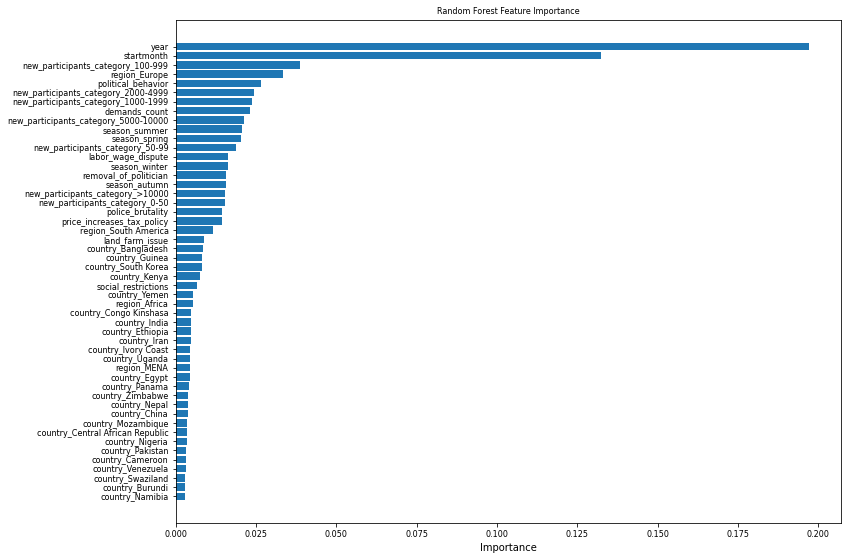

In [28]:
plt.barh('feature','importance',data=sorted_feat50)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig('15b_Feature_Importance.png')

## Logistic Regression <a class="anchor" id="Log"></a>

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

#Setting up x and y
X = df_encoded
features_list = df_encoded.columns
y = np.ravel(df_target)

In [43]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [44]:
# Setting up hyperparameter grid
c_space = [0.0001, 0.001, .01, .1, .5, 1, 10]
param_grid = {'C': c_space}

In [45]:
# Creating default model : logistic regression
logreg = LogisticRegression()

In [46]:
#Creating grid Search with log reg and cv=5
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')

In [47]:
# Fitting to training data
logreg_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Best Model Parameters: {}".format(logreg_cv.best_params_)) 
print("Best AUC-ROC score is {}".format(logreg_cv.best_score_))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best Model Parameters: {'C': 0.5}
Best AUC-ROC score is 0.7478675828490925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest <a class="anchor" id="random_forest"></a>

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Setting up x and y
X = df_encoded
features_list = df_encoded.columns
y = np.ravel(df_target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Setting up hyperparameter grid
n_estimators = np.arange(50, 400, 50)#number of trees in Forest
max_depth = np.arange(1,8)#depth of trees
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depth}

# Creating default model : random forest 
rf = RandomForestClassifier()
# Creating grid Search with log reg and cv=5
rf_cv = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')

# Fitting the model
rf_cv.fit(X_train, y_train)

print("Best Random Forest Parameters: {}".format(rf_cv.best_params_)) 
print("Best score is {}".format(rf_cv.best_score_))

Best Random Forest Parameters: {'max_depth': 7, 'n_estimators': 200}
Best score is 0.7671881738699942


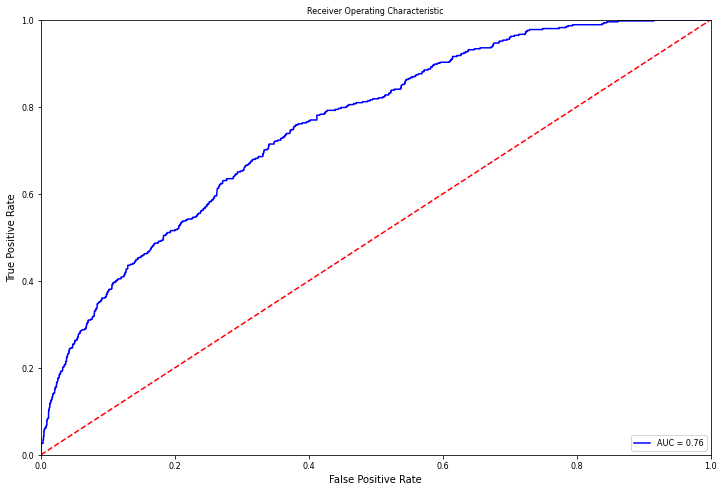

In [49]:
import sklearn.metrics as metrics
# calculate the false positive rate and true positive rate for all thresholds of the classification
probs = rf_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plotting with matplotlib

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Gradient Boosting <a class="anchor" id="gradient"></a>

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

X = df_encoded
y = np.ravel(df_target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

n_estimators = np.arange(100,600,100)
max_depth = [1,2,4,8]
learning_rate = [.05,.1,.2,.5,1]

param_dist = {'n_estimators': n_estimators, 'max_depth':max_depth, 'learning_rate':learning_rate}

gbm = GradientBoostingClassifier()

#RandomSearchCV object: 
gbm_cv = RandomizedSearchCV(gbm, param_distributions = param_dist, cv=5, scoring='roc_auc', n_iter=30)

#Fitting the model
gbm_cv.fit(X_train, y_train)

print("Best Gradient Boosting Parameters: {}".format(gbm_cv.best_params_)) 
print("Best score is {}".format(gbm_cv.best_score_))

Best Gradient Boosting Parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1}
Best score is 0.7911945848734335


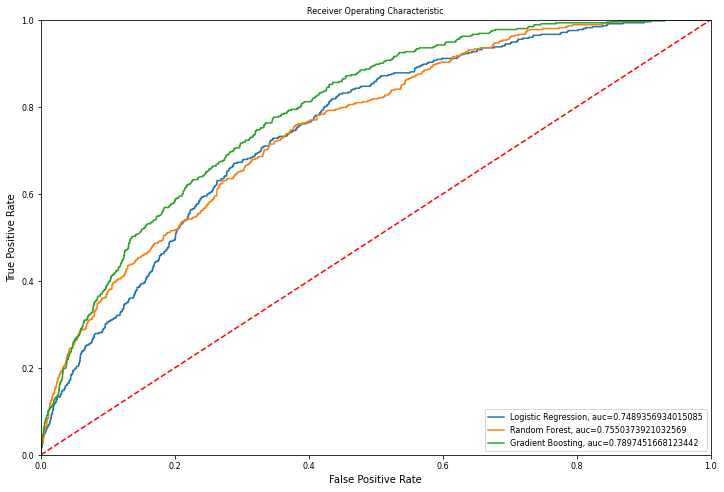

In [51]:
from sklearn import metrics

plt.figure(0).clf()
# calculate the false positive rate and true positive rate for all thresholds of the classification
#Log reg
probs = logreg_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(roc_auc))

#randomforest
probs = rf_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(roc_auc))

#GradientBoost
probs = gbm_cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="Gradient Boosting, auc="+str(roc_auc))



# plotting with matplotlib
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('AUC_updated.png')
plt.show()